In [57]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import classification_report, make_scorer, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import KFold, train_test_split, cross_validate, RepeatedStratifiedKFold, GridSearchCV, cross_val_score
import numpy as np
from imblearn.combine import SMOTETomek, SMOTEENN
from collections import Counter
from imblearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
import seaborn as sns
import sys
sys.path.append('/Users/ayoucruz/Desktop/Data_Science/3nd_Semester/DATA7901 Capstone project/Capstone/Models/Functions')
from Evaluation import *
from Preparation import *
import pickle

In [58]:
X, y, data = preparation_class_threshold()

/Users/ayoucruz/Desktop/Data_Science/3nd_Semester/DATA7901 Capstone project/Capstone/Models/Functions/Preparation.py:711: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_location = pd.read_csv('../../Dataset/Location.csv')


In [59]:
weather_features = ['Crash_Road_Surface_Condition_Sealed - Dry','Crash_Road_Surface_Condition_Sealed - Wet', 
                    'Crash_Road_Surface_Condition_Unsealed - Dry','Crash_Road_Surface_Condition_Unsealed - Wet', 
                    'Crash_Atmospheric_Condition_Clear', 'Crash_Atmospheric_Condition_Fog','Crash_Atmospheric_Condition_Raining',
                    'Crash_Atmospheric_Condition_Smoke/Dust', 'Crash_Lighting_Condition_Darkness - Lighted',
                    'Crash_Lighting_Condition_Darkness - Not lighted','Crash_Lighting_Condition_Dawn/Dusk','Crash_Lighting_Condition_Daylight',
                    'Crash_Road_Horiz_Align_Curved - view obscured','Crash_Road_Horiz_Align_Curved - view open','Crash_Road_Horiz_Align_Straight', 
                    'Crash_Road_Vert_Align_Crest', 'Crash_Road_Vert_Align_Dip', 'Crash_Road_Vert_Align_Grade','Crash_Road_Vert_Align_Level']

new_features =['Crash_Speed_Limit_100 - 110 km/h', 'Crash_Speed_Limit_60 km/h', 'Crash_Speed_Limit_80 - 90 km/h','Crash_Roadway_Feature_No Roadway Feature',
               'Crash_Speed_Limit_0 - 50 km/h','Crash_Traffic_Control_No traffic control','Crash_Nature_Hit object', 'Crash_Nature_Fall from vehicle',
               'Crash_Controlling_Authority_Locally-controlled', 'Crash_Nature_Rear-end','Crash_Nature_Angle','Crash_Month_Q2','Crash_Nature_Hit pedestrian']
X = X[weather_features + new_features]

### MLP Architecture

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.hidden1 = nn.Linear(32, 64)
        self.dropout1 = nn.Dropout(0.5)  # Dropout after the first hidden layer
        self.hidden2 = nn.Linear(64, 32)
        self.dropout2 = nn.Dropout(0.5)  # Dropout after the second hidden layer
        self.output = nn.Linear(32, 4)

    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = self.dropout1(x)  # Apply dropout
        x = F.relu(self.hidden2(x))
        x = self.dropout2(x)  # Apply dropout
        x = self.output(x)
        return x

### Train test split with baseline

In [62]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

X_train_val, X_test, y_train_val, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

### Training function

In [63]:
def train_and_validate(model, train_loader, val_loader, optimizer, criterion, num_epochs):
    training_losses = []
    valid_losses = []
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, labels in tqdm(train_loader):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        training_loss = train_loss / len(train_loader.dataset)
        training_losses.append(training_loss)
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
        validation_loss = val_loss / len(val_loader.dataset)
        valid_losses.append(validation_loss)
        print(f'Epoch {epoch + 1}, Training Loss: {training_loss}, Validation Loss: {validation_loss}')
    return training_losses, valid_losses

### Evaluation function

In [64]:
def evaluate_model(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.numpy())
            y_true.extend(labels.numpy())

    evaluation_class_8_MLP(y_true, y_pred)

### SMOTE

In [65]:
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

X_train_val, X_test, y_train_val, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)
y_smote_tensor = torch.tensor(y_smote, dtype=torch.long)
X_smote_tensor = torch.tensor(X_smote, dtype=torch.float32)

In [66]:
train_data = TensorDataset(X_smote_tensor, y_smote_tensor)
val_data = TensorDataset(X_val, y_val)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=512, shuffle=True)
val_loader = DataLoader(val_data, batch_size=512, shuffle=False)
test_loader = DataLoader(test_data, batch_size=512, shuffle=False)

100%|██████████| 1101/1101 [00:04<00:00, 225.07it/s]


Epoch 1, Training Loss: 1.3207156964513507, Validation Loss: 1.322274913328736


100%|██████████| 1101/1101 [00:04<00:00, 240.82it/s]


Epoch 2, Training Loss: 1.2640130316282754, Validation Loss: 1.3130317837875787


100%|██████████| 1101/1101 [00:04<00:00, 274.46it/s]


Epoch 3, Training Loss: 1.2519656432547848, Validation Loss: 1.3137166565139917


100%|██████████| 1101/1101 [00:03<00:00, 291.33it/s]


Epoch 4, Training Loss: 1.2441091034455098, Validation Loss: 1.3063064684396195


100%|██████████| 1101/1101 [00:04<00:00, 271.32it/s]


Epoch 5, Training Loss: 1.237219077545524, Validation Loss: 1.308716657213701


100%|██████████| 1101/1101 [00:03<00:00, 279.07it/s]


Epoch 6, Training Loss: 1.2317233517609885, Validation Loss: 1.310236174967597


100%|██████████| 1101/1101 [00:04<00:00, 273.60it/s]


Epoch 7, Training Loss: 1.2275368405418703, Validation Loss: 1.3041036239630253


100%|██████████| 1101/1101 [00:04<00:00, 273.15it/s]


Epoch 8, Training Loss: 1.2240725558368863, Validation Loss: 1.3018893223724035


100%|██████████| 1101/1101 [00:04<00:00, 270.61it/s]


Epoch 9, Training Loss: 1.2212720450813173, Validation Loss: 1.3044562054222908


100%|██████████| 1101/1101 [00:03<00:00, 281.55it/s]


Epoch 10, Training Loss: 1.2187730447555745, Validation Loss: 1.2974916878382499


100%|██████████| 1101/1101 [00:04<00:00, 234.79it/s]


Epoch 11, Training Loss: 1.2160904463178028, Validation Loss: 1.2998042278039648


100%|██████████| 1101/1101 [00:04<00:00, 272.31it/s]


Epoch 12, Training Loss: 1.2145038427863466, Validation Loss: 1.2979854520249012


100%|██████████| 1101/1101 [00:04<00:00, 261.94it/s]


Epoch 13, Training Loss: 1.213053364498659, Validation Loss: 1.299170891678297


100%|██████████| 1101/1101 [00:04<00:00, 273.28it/s]


Epoch 14, Training Loss: 1.2111436903623947, Validation Loss: 1.295733006852175


100%|██████████| 1101/1101 [00:03<00:00, 284.13it/s]


Epoch 15, Training Loss: 1.2104914886798936, Validation Loss: 1.2970462573613128


100%|██████████| 1101/1101 [00:04<00:00, 250.20it/s]


Epoch 16, Training Loss: 1.208554134841117, Validation Loss: 1.297264644359495


100%|██████████| 1101/1101 [00:04<00:00, 244.89it/s]


Epoch 17, Training Loss: 1.2074615741073231, Validation Loss: 1.2952589499338854


100%|██████████| 1101/1101 [00:04<00:00, 272.93it/s]


Epoch 18, Training Loss: 1.206960175097021, Validation Loss: 1.300217769827341


100%|██████████| 1101/1101 [00:04<00:00, 263.43it/s]


Epoch 19, Training Loss: 1.2054158403006916, Validation Loss: 1.2930958128749013


100%|██████████| 1101/1101 [00:04<00:00, 264.87it/s]


Epoch 20, Training Loss: 1.2042345766659568, Validation Loss: 1.2935671381009564


100%|██████████| 1101/1101 [00:03<00:00, 278.47it/s]


Epoch 21, Training Loss: 1.2036373405960714, Validation Loss: 1.2878113359065324


100%|██████████| 1101/1101 [00:04<00:00, 272.57it/s]


Epoch 22, Training Loss: 1.2025774023181612, Validation Loss: 1.292284738988604


100%|██████████| 1101/1101 [00:03<00:00, 279.86it/s]


Epoch 23, Training Loss: 1.201730078125233, Validation Loss: 1.2953240275069056


100%|██████████| 1101/1101 [00:03<00:00, 276.20it/s]


Epoch 24, Training Loss: 1.2014518256169975, Validation Loss: 1.2928482869974143


100%|██████████| 1101/1101 [00:04<00:00, 260.45it/s]


Epoch 25, Training Loss: 1.2007174497737696, Validation Loss: 1.2955737591894865


100%|██████████| 1101/1101 [00:04<00:00, 270.26it/s]


Epoch 26, Training Loss: 1.2002111579127608, Validation Loss: 1.290718503386633


100%|██████████| 1101/1101 [00:04<00:00, 248.25it/s]


Epoch 27, Training Loss: 1.199362931572793, Validation Loss: 1.2873470010187833


100%|██████████| 1101/1101 [00:04<00:00, 266.99it/s]


Epoch 28, Training Loss: 1.1983854795841886, Validation Loss: 1.2947189274319455


100%|██████████| 1101/1101 [00:04<00:00, 257.26it/s]


Epoch 29, Training Loss: 1.1977714694496355, Validation Loss: 1.291337213375088


100%|██████████| 1101/1101 [00:04<00:00, 269.15it/s]


Epoch 30, Training Loss: 1.1979035870903874, Validation Loss: 1.29117940524023
Accuracy:  0.22467871062888445
Precision:  0.6199288309621687
Recall:  0.22467871062888445
F1-Score:  0.18425496157973917
--------------------------------------------
                 precision    recall  f1-score   support

          Fatal       0.05      0.66      0.09      1197
   Minor injury       0.18      0.49      0.27     10365
Property damage       0.31      0.51      0.38     17428
 Serious injury       0.85      0.05      0.09     46954

       accuracy                           0.22     75944
      macro avg       0.35      0.43      0.21     75944
   weighted avg       0.62      0.22      0.18     75944



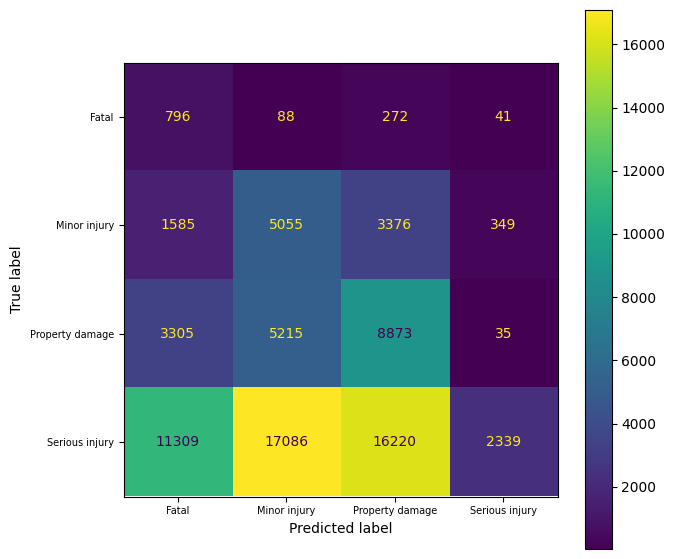

In [67]:
model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
training_losses, valid_losses = train_and_validate(model, train_loader, val_loader, optimizer, criterion, num_epochs=30)

evaluate_model(model, test_loader)

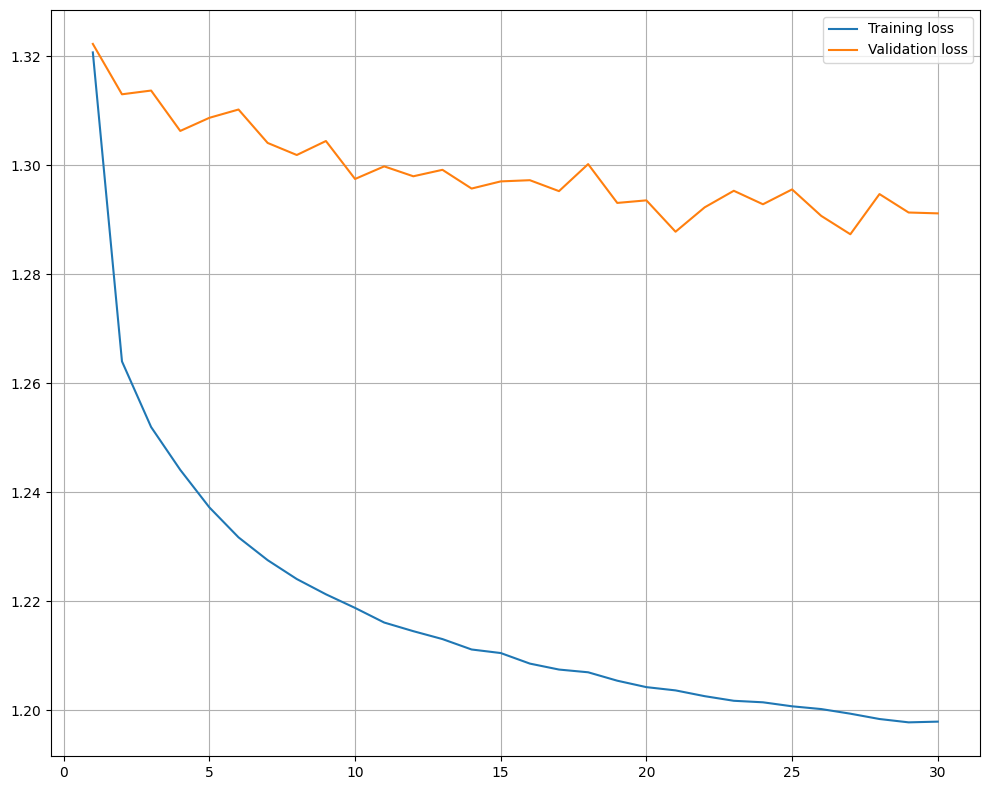

In [68]:
epochs = np.arange(1,31)
plt.figure(figsize=(10, 8))
plt.plot(epochs, training_losses, label="Training loss")
plt.plot(epochs, valid_losses, label="Validation loss")
plt.tight_layout()
plt.legend()
plt.grid()
plt.show()

100%|██████████| 1101/1101 [00:04<00:00, 269.20it/s]


Epoch 1, Training Loss: 1.3891435865276747, Validation Loss: 1.349357497123249


100%|██████████| 1101/1101 [00:04<00:00, 255.40it/s]


Epoch 2, Training Loss: 1.3788532879435087, Validation Loss: 1.3519142709290228


100%|██████████| 1101/1101 [00:04<00:00, 250.73it/s]


Epoch 3, Training Loss: 1.3583754267935852, Validation Loss: 1.351117860802506


100%|██████████| 1101/1101 [00:03<00:00, 279.12it/s]


Epoch 4, Training Loss: 1.3314509935183534, Validation Loss: 1.3497042449121164


100%|██████████| 1101/1101 [00:03<00:00, 278.27it/s]


Epoch 5, Training Loss: 1.3135733604532691, Validation Loss: 1.3444016864952015


100%|██████████| 1101/1101 [00:03<00:00, 288.40it/s]


Epoch 6, Training Loss: 1.3034513985046905, Validation Loss: 1.3422509765745554


100%|██████████| 1101/1101 [00:03<00:00, 275.69it/s]


Epoch 7, Training Loss: 1.2955311023546936, Validation Loss: 1.340682610726565


100%|██████████| 1101/1101 [00:04<00:00, 274.38it/s]


Epoch 8, Training Loss: 1.2894193791019082, Validation Loss: 1.3361694400006372


100%|██████████| 1101/1101 [00:03<00:00, 277.54it/s]


Epoch 9, Training Loss: 1.2843863890160965, Validation Loss: 1.3351807518576992


100%|██████████| 1101/1101 [00:04<00:00, 269.94it/s]


Epoch 10, Training Loss: 1.2808291935500347, Validation Loss: 1.332979637843395


100%|██████████| 1101/1101 [00:04<00:00, 252.53it/s]


Epoch 11, Training Loss: 1.2765878212146982, Validation Loss: 1.3313715918403424


100%|██████████| 1101/1101 [00:05<00:00, 216.46it/s]


Epoch 12, Training Loss: 1.2739049859118825, Validation Loss: 1.329743782109962


100%|██████████| 1101/1101 [00:04<00:00, 242.08it/s]


Epoch 13, Training Loss: 1.2717705399880217, Validation Loss: 1.327971203578582


100%|██████████| 1101/1101 [00:04<00:00, 270.27it/s]


Epoch 14, Training Loss: 1.2695338057245098, Validation Loss: 1.3267535386893716


100%|██████████| 1101/1101 [00:04<00:00, 273.79it/s]


Epoch 15, Training Loss: 1.2671940471687295, Validation Loss: 1.3260800117538687


100%|██████████| 1101/1101 [00:04<00:00, 254.73it/s]


Epoch 16, Training Loss: 1.2653379283735637, Validation Loss: 1.3252458170418944


100%|██████████| 1101/1101 [00:04<00:00, 267.20it/s]


Epoch 17, Training Loss: 1.263880230272951, Validation Loss: 1.3249081396195128


100%|██████████| 1101/1101 [00:04<00:00, 251.64it/s]


Epoch 18, Training Loss: 1.2622313271226544, Validation Loss: 1.3225047504714778


100%|██████████| 1101/1101 [00:03<00:00, 275.97it/s]


Epoch 19, Training Loss: 1.2608683578322468, Validation Loss: 1.3225876961519907


100%|██████████| 1101/1101 [00:04<00:00, 238.59it/s]


Epoch 20, Training Loss: 1.259220463647228, Validation Loss: 1.3221768497303088


100%|██████████| 1101/1101 [00:04<00:00, 223.32it/s]


Epoch 21, Training Loss: 1.2585548630754735, Validation Loss: 1.3208328821279096


100%|██████████| 1101/1101 [00:04<00:00, 255.44it/s]


Epoch 22, Training Loss: 1.257400470634785, Validation Loss: 1.32048041722828


100%|██████████| 1101/1101 [00:04<00:00, 250.44it/s]


Epoch 23, Training Loss: 1.256377739806262, Validation Loss: 1.319913950657601


100%|██████████| 1101/1101 [00:04<00:00, 257.37it/s]


Epoch 24, Training Loss: 1.2554194605576248, Validation Loss: 1.3196330142701802


100%|██████████| 1101/1101 [00:04<00:00, 261.93it/s]


Epoch 25, Training Loss: 1.2538561321077237, Validation Loss: 1.3186125549867735


100%|██████████| 1101/1101 [00:04<00:00, 256.88it/s]


Epoch 26, Training Loss: 1.2532394945728105, Validation Loss: 1.3185131577964226


100%|██████████| 1101/1101 [00:04<00:00, 262.28it/s]


Epoch 27, Training Loss: 1.2518292880539579, Validation Loss: 1.3182596864482317


100%|██████████| 1101/1101 [00:04<00:00, 263.81it/s]


Epoch 28, Training Loss: 1.2511297806656168, Validation Loss: 1.316452058401623


100%|██████████| 1101/1101 [00:04<00:00, 268.74it/s]


Epoch 29, Training Loss: 1.2498863820867743, Validation Loss: 1.3162740466341787


100%|██████████| 1101/1101 [00:04<00:00, 252.92it/s]


Epoch 30, Training Loss: 1.249645760483042, Validation Loss: 1.3153479398018968
Accuracy:  0.19045612556620667
Precision:  0.54823488836495
Recall:  0.19045612556620667
F1-Score:  0.14515987688528034
--------------------------------------------
                 precision    recall  f1-score   support

          Fatal       0.04      0.74      0.08      1197
   Minor injury       0.18      0.53      0.27     10365
Property damage       0.32      0.41      0.36     17428
 Serious injury       0.73      0.02      0.04     46954

       accuracy                           0.19     75944
      macro avg       0.32      0.42      0.19     75944
   weighted avg       0.55      0.19      0.15     75944



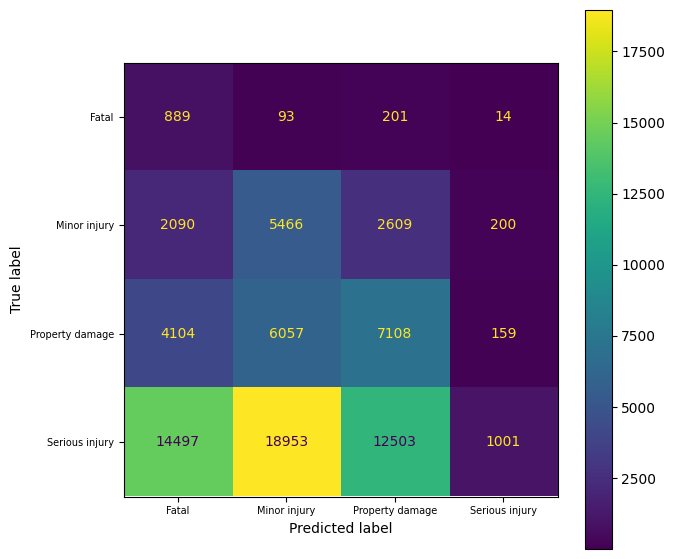

In [69]:
model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)
training_losses, valid_losses = train_and_validate(model, train_loader, val_loader, optimizer, criterion, num_epochs=30)

evaluate_model(model, test_loader)

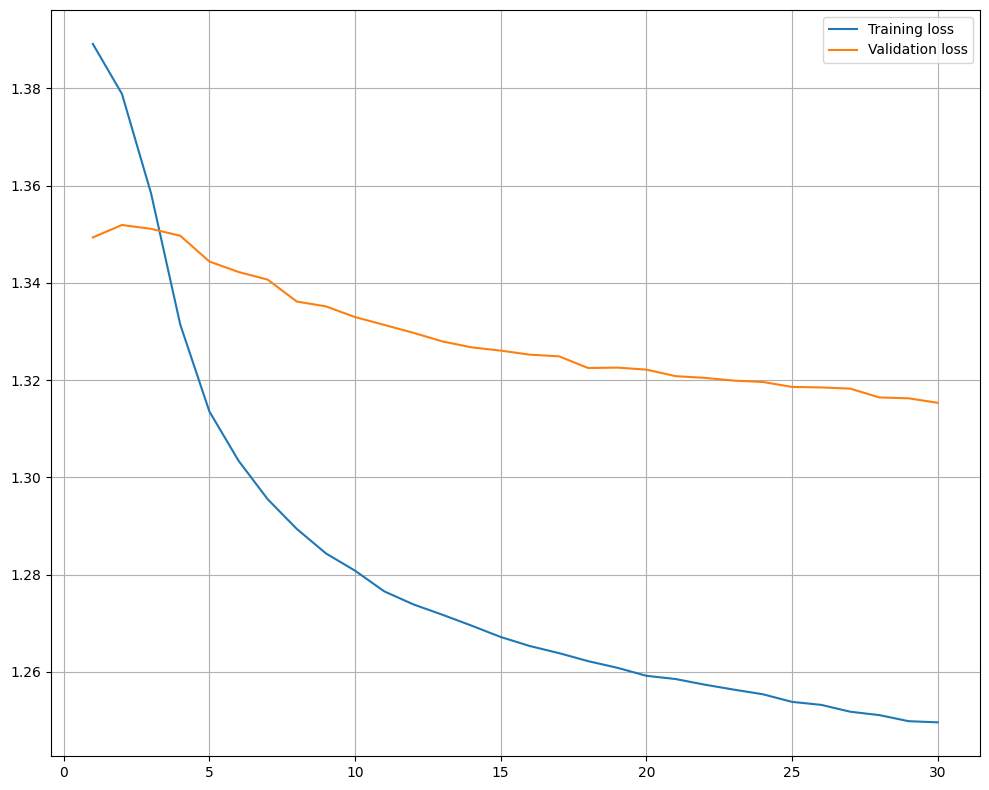

In [70]:
epochs = np.arange(1,31)
plt.figure(figsize=(10, 8))
plt.plot(epochs, training_losses, label="Training loss")
plt.plot(epochs, valid_losses, label="Validation loss")
plt.tight_layout()
plt.legend()
plt.grid()
plt.show()

100%|██████████| 1101/1101 [00:04<00:00, 268.50it/s]


Epoch 1, Training Loss: 1.3974551734138816, Validation Loss: 1.4261816715171964


100%|██████████| 1101/1101 [00:04<00:00, 268.02it/s]


Epoch 2, Training Loss: 1.3961367305108099, Validation Loss: 1.4227240416368971


100%|██████████| 1101/1101 [00:04<00:00, 255.09it/s]


Epoch 3, Training Loss: 1.3949337341740686, Validation Loss: 1.4193784782334724


100%|██████████| 1101/1101 [00:04<00:00, 257.21it/s]


Epoch 4, Training Loss: 1.3939617249165615, Validation Loss: 1.4161619737479052


100%|██████████| 1101/1101 [00:04<00:00, 268.84it/s]


Epoch 5, Training Loss: 1.3928182016817932, Validation Loss: 1.4131463231772174


100%|██████████| 1101/1101 [00:04<00:00, 259.37it/s]


Epoch 6, Training Loss: 1.3918425656032436, Validation Loss: 1.410179076349975


100%|██████████| 1101/1101 [00:04<00:00, 273.87it/s]


Epoch 7, Training Loss: 1.3908211430882964, Validation Loss: 1.4072866077909325


100%|██████████| 1101/1101 [00:04<00:00, 269.41it/s]


Epoch 8, Training Loss: 1.389951337240464, Validation Loss: 1.4045612044145044


100%|██████████| 1101/1101 [00:04<00:00, 272.12it/s]


Epoch 9, Training Loss: 1.3889407134334306, Validation Loss: 1.4017961443908395


100%|██████████| 1101/1101 [00:04<00:00, 263.57it/s]


Epoch 10, Training Loss: 1.3881454493361076, Validation Loss: 1.3992927688624552


100%|██████████| 1101/1101 [00:04<00:00, 268.31it/s]


Epoch 11, Training Loss: 1.3870931240272246, Validation Loss: 1.396872615306882


100%|██████████| 1101/1101 [00:04<00:00, 262.62it/s]


Epoch 12, Training Loss: 1.386022382814025, Validation Loss: 1.3944534542537221


100%|██████████| 1101/1101 [00:04<00:00, 265.74it/s]


Epoch 13, Training Loss: 1.3850090099401164, Validation Loss: 1.3920896682826658


100%|██████████| 1101/1101 [00:04<00:00, 270.53it/s]


Epoch 14, Training Loss: 1.3839030138445294, Validation Loss: 1.3898726413539548


100%|██████████| 1101/1101 [00:04<00:00, 262.38it/s]


Epoch 15, Training Loss: 1.382759323163034, Validation Loss: 1.3878050748834516


100%|██████████| 1101/1101 [00:04<00:00, 272.93it/s]


Epoch 16, Training Loss: 1.3817766837307996, Validation Loss: 1.385766541707959


100%|██████████| 1101/1101 [00:04<00:00, 260.70it/s]


Epoch 17, Training Loss: 1.3805792889072854, Validation Loss: 1.3837429933775014


100%|██████████| 1101/1101 [00:04<00:00, 270.88it/s]


Epoch 18, Training Loss: 1.3795454372407523, Validation Loss: 1.3818077079415712


100%|██████████| 1101/1101 [00:04<00:00, 273.98it/s]


Epoch 19, Training Loss: 1.3781651274985516, Validation Loss: 1.3799619049942056


100%|██████████| 1101/1101 [00:04<00:00, 270.21it/s]


Epoch 20, Training Loss: 1.3765895173915257, Validation Loss: 1.3781952573290417


100%|██████████| 1101/1101 [00:03<00:00, 276.25it/s]


Epoch 21, Training Loss: 1.3754775180669352, Validation Loss: 1.3764282953973994


100%|██████████| 1101/1101 [00:03<00:00, 276.08it/s]


Epoch 22, Training Loss: 1.3738766084561196, Validation Loss: 1.374759155820145


100%|██████████| 1101/1101 [00:04<00:00, 273.79it/s]


Epoch 23, Training Loss: 1.3723584837789096, Validation Loss: 1.3730233399367968


100%|██████████| 1101/1101 [00:04<00:00, 268.89it/s]


Epoch 24, Training Loss: 1.3706019089171253, Validation Loss: 1.3713998472327669


100%|██████████| 1101/1101 [00:03<00:00, 277.13it/s]


Epoch 25, Training Loss: 1.3688732570231914, Validation Loss: 1.3697408669667739


100%|██████████| 1101/1101 [00:04<00:00, 273.12it/s]


Epoch 26, Training Loss: 1.367248675015035, Validation Loss: 1.368172401838404


100%|██████████| 1101/1101 [00:04<00:00, 269.29it/s]


Epoch 27, Training Loss: 1.3652310002172003, Validation Loss: 1.3666236326388836


100%|██████████| 1101/1101 [00:04<00:00, 273.70it/s]


Epoch 28, Training Loss: 1.3635207924755242, Validation Loss: 1.3650834972157966


100%|██████████| 1101/1101 [00:04<00:00, 274.97it/s]


Epoch 29, Training Loss: 1.3614557071471451, Validation Loss: 1.3636222504142914


100%|██████████| 1101/1101 [00:04<00:00, 272.15it/s]


Epoch 30, Training Loss: 1.3594432761229769, Validation Loss: 1.3621498995305463
Accuracy:  0.3399610239123565
Precision:  0.5100959984641523
Recall:  0.3399610239123565
F1-Score:  0.3613558404432443
--------------------------------------------
                 precision    recall  f1-score   support

          Fatal       0.04      0.69      0.07      1197
   Minor injury       0.17      0.30      0.22     10365
Property damage       0.46      0.01      0.01     17428
 Serious injury       0.62      0.46      0.53     46954

       accuracy                           0.34     75944
      macro avg       0.32      0.37      0.21     75944
   weighted avg       0.51      0.34      0.36     75944



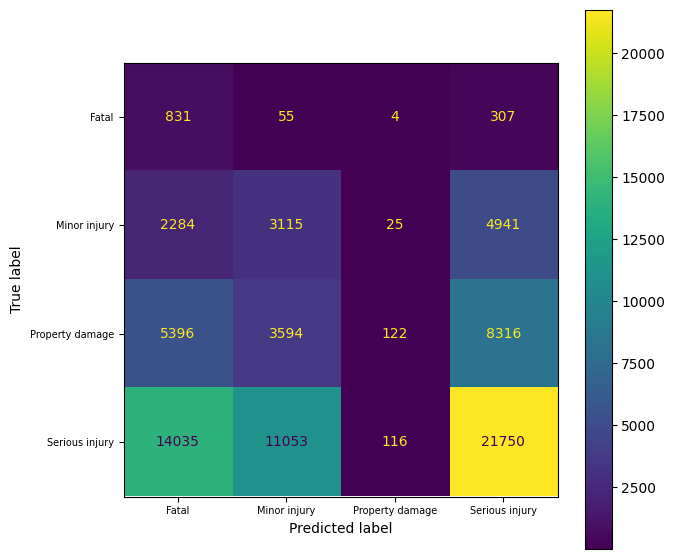

In [71]:
model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.000001)
training_losses, valid_losses = train_and_validate(model, train_loader, val_loader, optimizer, criterion, num_epochs=30)

evaluate_model(model, test_loader)

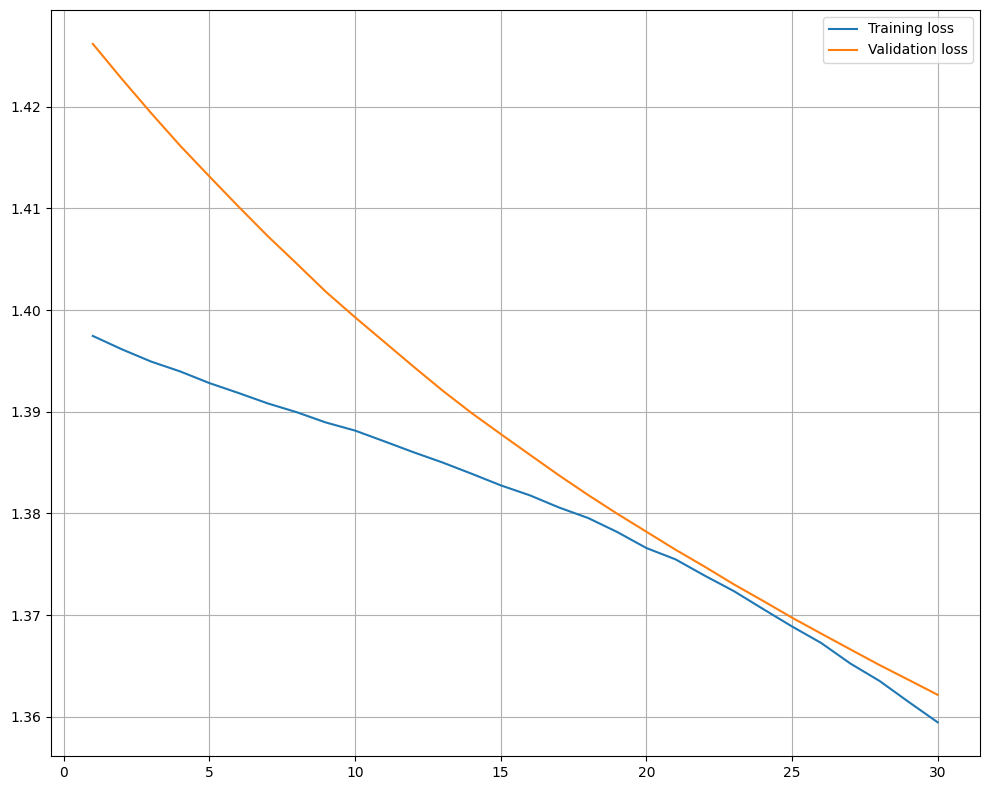

In [72]:
epochs = np.arange(1,31)
plt.figure(figsize=(10, 8))
plt.plot(epochs, training_losses, label="Training loss")
plt.plot(epochs, valid_losses, label="Validation loss")
plt.tight_layout()
plt.legend()
plt.grid()
plt.show()